In [235]:
from math import sqrt
from numpy import concatenate
import numpy as np
from numpy import array

import keras
from keras.models import Sequential
from keras.layers import LSTM, BatchNormalization
from keras.layers import Dense
from keras.layers import Bidirectional
from keras.utils import to_categorical
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.optimizers import SGD
import tensorflow as tf

from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot
from sodapy import Socrata


In [2]:
# # Uncomment the below to open data source, download sensor data, and store it as a csv locally.

# #Function to get Sensor count history data
# def sensor_count():
#     client = Socrata('data.melbourne.vic.gov.au', 'nlPM0PQJSjzCsbVqntjPvjB1f', None)
#     sensor_data_id = "b2ak-trbp"
#     results = client.get(sensor_data_id, limit=5000000)
#     df = pd.DataFrame.from_records(results)
#     df = df[['date_time', 'year', 'month', 'mdate', 'day', 'time', 'sensor_id', 'sensor_name', 'hourly_counts']]
#     return df

# sensor_history = sensor_count()

# sensor_history.to_csv('sensor_history.csv', index=False)

In [275]:
sensor_history = pd.read_csv('sensor_history.csv')

In [276]:
single_sensor = sensor_history[sensor_history.sensor_id == 4].copy()
single_sensor.sort_values('date_time', inplace=True, ascending=True)

In [277]:
#Make sensor counts range from 0 to 1.
maximum = single_sensor.hourly_counts.max()
single_sensor['hourly_counts'] = single_sensor['hourly_counts']/maximum

Now, it is important to understand that a model that attempts to make predictions on a time series can have reasonably good success by simply copying the value of the previous time step. In most cases, this value will be close to the next value in the sequence - and this can give the appearance of predictive ability where there is actually none.

So before building models and evaluating them, it is worthwhile setting up a baseline. This is the performance attained by simply copying the hourly count from the previous time step.

In [278]:
true_count = single_sensor.hourly_counts.to_numpy()
prev_count = true_count[1:true_count.shape[0]]
r2_baseline = r2_score(prev_count, true_count[0:true_count.shape[0]-1])   
print("The baseline R-squared score is:", r2_baseline)

The baseline R-squared score is: 0.8835439180056677


From this example we can see a fairly convincing score (at the time of writing this comment, it was around 0.884). However, we know that the model we just made is useless for our purposes.
We need to improve on this score!

In [279]:
sensor_seq = []
for i in range(0, len(single_sensor)):
    sensor_seq.append(single_sensor.hourly_counts.iloc[i])

In [303]:
# split a univariate sequence
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# choose a number of time steps
n_steps = 168
# split into samples
X, y = split_sequence(sensor_seq, n_steps)


In [304]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))


In [287]:
X_train = X[10001:80000]
X_val = X[80001:]
X_test = X[:10000]
Y_train = y[10001:80000]
Y_val = y[80001:]
Y_test = y[:10000]

In [308]:
X_train = X[15001:25000]
X_val = X[25001:30000]
X_test = X[:10000]
Y_train = y[15001:25000]
Y_val = y[25001:30000]
Y_test = y[:10000]

In [309]:
epochs = 50
learning_rate = 0.00001
decay_rate = learning_rate / epochs
momentum = 0.8

# define model
model = Sequential()
model.add(Bidirectional(LSTM(48, return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2]))))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(LSTM(48, return_sequences=True, input_shape=(n_steps, n_features)))
model.add(Dropout(0.2))
model.add(LSTM(96, return_sequences=True, input_shape=(n_steps, n_features)))
model.add(Dropout(0.2))
model.add(LSTM(120, return_sequences=True, input_shape=(n_steps, n_features)))
model.add(Dropout(0.2))
model.add(LSTM(196, input_shape=(n_steps, n_features)))
model.add(Dropout(0.2))
model.add(Dense(48, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

opt = keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=opt, loss='mse')


In [310]:
# fit model
model.fit(X_train, Y_train, validation_data =(X_val, Y_val), epochs=45, verbose=1, batch_size = 64)


Epoch 1/45
157/157 [==============================] - 214s 1s/step - loss: 0.1199 - val_loss: 0.1159
Epoch 2/45
157/157 [==============================] - 212s 1s/step - loss: 0.0537 - val_loss: 0.0330
Epoch 3/45
157/157 [==============================] - 210s 1s/step - loss: 0.0272 - val_loss: 0.0264
Epoch 4/45
157/157 [==============================] - 222s 1s/step - loss: 0.0266 - val_loss: 0.0260
Epoch 5/45
157/157 [==============================] - 214s 1s/step - loss: 0.0265 - val_loss: 0.0258
Epoch 6/45
157/157 [==============================] - 216s 1s/step - loss: 0.0260 - val_loss: 0.0252
Epoch 7/45
157/157 [==============================] - 220s 1s/step - loss: 0.0247 - val_loss: 0.0226
Epoch 8/45
157/157 [==============================] - 223s 1s/step - loss: 0.0199 - val_loss: 0.0136
Epoch 9/45
157/157 [==============================] - 216s 1s/step - loss: 0.0100 - val_loss: 0.0071
Epoch 10/45
157/157 [==============================] - 213s 1s/step - loss: 0.0059 - val_lo

In [292]:
# demonstrate prediction
x_input = array(sensor_seq[10001:10393])
# x_input = x_input/maximum
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print("predicted next value: ", yhat * maximum)
print("actual next value: ", sensor_seq[10393] * maximum)

ValueError: cannot reshape array of size 392 into shape (1,72,1)

In [ ]:
# demonstrate prediction
x_input = array(sensor_seq[10021:10413])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print("predicted next value: ", yhat * maximum)
print("actual next value: ", sensor_seq[10413] * maximum)

In [311]:
pred = model.predict(X_test)

In [312]:
r2_score(Y_test, pred)

0.9187243829637375

In [316]:
import matplotlib.pyplot as plt

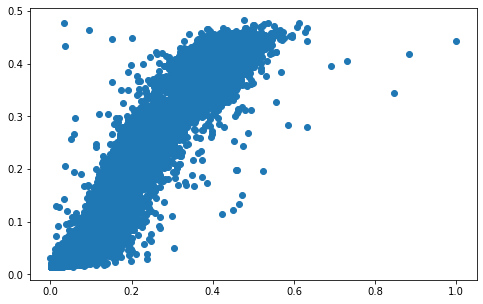

In [333]:
plt.figure(figsize=(8,5))
# plt.plot(Y_test)
# plt.plot(pred)
plt.scatter(Y_test, pred)
plt.show()

In [ ]:
# model.save("model_3.h5")

In [ ]:
# #Function to get Sensor count history data
# def micro_count():
#     client = Socrata('data.melbourne.vic.gov.au', 'nlPM0PQJSjzCsbVqntjPvjB1f', None)
#     micro_data_id = "u4vh-84j8"
#     results = client.get(micro_data_id, limit=4000000)
#     if results:
#         df = pd.DataFrame.from_records(results)
#     return df

# micro_history = micro_count()

# micro_history.to_csv('micro_history.csv', index=False)

In [5]:
micro_history = pd.read_csv('micro_history.csv')

micro_history = micro_history[(micro_history.sensor_id == '5a') | (micro_history.sensor_id == '5b') |
                             (micro_history.sensor_id == '5c') | (micro_history.sensor_id == '0a') |
                             (micro_history.sensor_id == '0b') | (micro_history.sensor_id == '6')]

micro_history = micro_history[(micro_history.site_id == 1003) | (micro_history.site_id == 1009)]

micro_history = micro_history.drop(['id', 'gateway_hub_id', 'type', 'units'], axis=1)

micro_history.loc[micro_history.sensor_id == '5a', 'temp'] = micro_history.value
micro_history.loc[micro_history.sensor_id == '5b', 'humidity'] = micro_history.value
micro_history.loc[micro_history.sensor_id == '5c', 'pressure'] = micro_history.value
micro_history.loc[micro_history.sensor_id == '0a', 'part_2p5'] = micro_history.value
micro_history.loc[micro_history.sensor_id == '0b', 'part_10'] = micro_history.value
micro_history.loc[micro_history.sensor_id == '6', 'wind'] = micro_history.value

micro_history.local_time = pd.to_datetime(micro_history.local_time, format='%Y-%m-%d')
micro_history['year'] = micro_history.local_time.dt.year
micro_history['month'] = micro_history.local_time.dt.month_name()
micro_history['mdate'] = micro_history.local_time.dt.day
micro_history['time'] = micro_history.local_time.dt.hour

micro_history = micro_history.drop(['site_id', 'sensor_id', 'value', 'local_time'], axis=1)
micro_history = micro_history.groupby(by=['year', 'month', 'mdate', 'time']).max()

ped_climate = sensor_history.merge(micro_history, on=('year', 'month', 'mdate', 'time'), how='inner')

In [219]:
single_sensor_climate = ped_climate.loc[ped_climate.sensor_name == 'Town Hall (West)'].copy()

In [220]:
single_sensor_climate.fillna(method='ffill', inplace = True)

In [221]:
single_sensor_climate.head()

,date_time,year,month,mdate,day,time,sensor_id,sensor_name,hourly_counts,temp,humidity,pressure,part_2p5,part_10,wind
512,2019-11-15T09:00:00.000,2019,November,15,Friday,9,4,Town Hall (West),1430,15.41,66.14,1008.0,4.5,18.4,7.92
567,2019-11-15T10:00:00.000,2019,November,15,Friday,10,4,Town Hall (West),2101,16.12,59.41,1008.0,4.2,20.0,7.88
622,2019-11-15T11:00:00.000,2019,November,15,Friday,11,4,Town Hall (West),2577,16.90,57.53,1007.9,4.1,20.1,7.92
677,2019-11-15T12:00:00.000,2019,November,15,Friday,12,4,Town Hall (West),3439,18.73,54.64,1007.5,4.5,23.1,9.68
732,2019-11-15T13:00:00.000,2019,November,15,Friday,13,4,Town Hall (West),4043,18.78,51.06,1006.7,4.1,18.7,10.44


In [222]:
single_sensor_climate.drop(['date_time', 'year', 'sensor_id', 'sensor_name', 'mdate'], axis = 1, inplace = True)

In [223]:
single_sensor_climate.head()

,month,day,time,hourly_counts,temp,humidity,pressure,part_2p5,part_10,wind
512,November,Friday,9,1430,15.41,66.14,1008.0,4.5,18.4,7.92
567,November,Friday,10,2101,16.12,59.41,1008.0,4.2,20.0,7.88
622,November,Friday,11,2577,16.90,57.53,1007.9,4.1,20.1,7.92
677,November,Friday,12,3439,18.73,54.64,1007.5,4.5,23.1,9.68
732,November,Friday,13,4043,18.78,51.06,1006.7,4.1,18.7,10.44


In [224]:
month_dict = {'January' : 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7,
              'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}
day_dict = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}

In [225]:
single_sensor_climate.replace({'month': month_dict, 'day': day_dict}, inplace = True)

In [226]:
scaler = MinMaxScaler()

In [227]:
scaled = scaler.fit_transform(single_sensor_climate)

In [228]:
new_sequence = np.zeros((scaled.shape[0], scaled.shape[1]+1), dtype=float)

In [229]:
for i in range (0, scaled.shape[0]-1):
    new_sequence[i][0:9] = scaled[i][0:9]
    new_sequence[i][10] = scaled[i+1][3]

In [230]:
train = new_sequence[0:12000, :]
test = new_sequence[12000:15000, :]
val = new_sequence[15000:,:]

In [231]:
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
val_x, val_y = val[:, :-1], val[:, -1]

In [232]:
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
val_x = val_x.reshape((val_x.shape[0], 1, val_x.shape[1]))

In [236]:
epochs = 50
learning_rate = 0.00001
decay_rate = learning_rate / epochs
momentum = 0.8

# define model
model = Sequential()
model.add(Bidirectional(LSTM(48, return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2]))))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(LSTM(96, return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(120, return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(196, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(48, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

opt = keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=opt, loss='mse')

In [ ]:
# epochs = 50
# learning_rate = 0.00001
# decay_rate = learning_rate / epochs
# momentum = 0.8

# # define model
# model = Sequential()
# model.add(LSTM(48, return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2])))
# model.add(Dropout(0.2))
# model.add(LSTM(96, return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2])))
# model.add(Dropout(0.2))
# model.add(LSTM(120, return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2])))
# model.add(Dropout(0.2))
# model.add(LSTM(196, input_shape=(train_x.shape[1], train_x.shape[2])))
# model.add(Dropout(0.2))
# model.add(Dense(48, kernel_initializer='normal', activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

# opt = keras.optimizers.Adam(learning_rate=learning_rate)

# model.compile(optimizer=opt, loss='mse')

In [237]:
model.fit(train_x, train_y, validation_data =(test_x, test_y), epochs=1000, verbose=1, batch_size = 64)

Epoch 1/1000
188/188 [==============================] - 4s 22ms/step - loss: 0.1640 - val_loss: 0.1584
Epoch 2/1000
188/188 [==============================] - 2s 9ms/step - loss: 0.1629 - val_loss: 0.1572
Epoch 3/1000
188/188 [==============================] - 2s 9ms/step - loss: 0.1613 - val_loss: 0.1555
Epoch 4/1000
188/188 [==============================] - 2s 9ms/step - loss: 0.1586 - val_loss: 0.1523
Epoch 5/1000
188/188 [==============================] - 2s 9ms/step - loss: 0.1526 - val_loss: 0.1450
Epoch 6/1000
188/188 [==============================] - 2s 9ms/step - loss: 0.1380 - val_loss: 0.1268
Epoch 7/1000
188/188 [==============================] - 2s 9ms/step - loss: 0.1104 - val_loss: 0.0997
Epoch 8/1000
188/188 [==============================] - 2s 9ms/step - loss: 0.0851 - val_loss: 0.0811
Epoch 9/1000
188/188 [==============================] - 2s 9ms/step - loss: 0.0716 - val_loss: 0.0714
Epoch 10/1000
188/188 [==============================] - 2s 9ms/step - loss: 0.06

188/188 [==============================] - 2s 9ms/step - loss: 0.0039 - val_loss: 0.0052
Epoch 81/1000
188/188 [==============================] - 2s 9ms/step - loss: 0.0039 - val_loss: 0.0052
Epoch 82/1000
188/188 [==============================] - 2s 9ms/step - loss: 0.0038 - val_loss: 0.0052
Epoch 83/1000
188/188 [==============================] - 2s 9ms/step - loss: 0.0038 - val_loss: 0.0052
Epoch 84/1000
188/188 [==============================] - 2s 9ms/step - loss: 0.0038 - val_loss: 0.0052
Epoch 85/1000
188/188 [==============================] - 2s 9ms/step - loss: 0.0037 - val_loss: 0.0051
Epoch 86/1000
188/188 [==============================] - 2s 9ms/step - loss: 0.0037 - val_loss: 0.0051
Epoch 87/1000
188/188 [==============================] - 2s 9ms/step - loss: 0.0037 - val_loss: 0.0051
Epoch 88/1000
188/188 [==============================] - 2s 9ms/step - loss: 0.0037 - val_loss: 0.0051
Epoch 89/1000
188/188 [==============================] - 2s 9ms/step - loss: 0.0037 - v

188/188 [==============================] - 2s 9ms/step - loss: 0.0034 - val_loss: 0.0048
Epoch 160/1000
188/188 [==============================] - 2s 9ms/step - loss: 0.0033 - val_loss: 0.0048
Epoch 161/1000
188/188 [==============================] - 2s 9ms/step - loss: 0.0033 - val_loss: 0.0048
Epoch 162/1000
188/188 [==============================] - 2s 9ms/step - loss: 0.0033 - val_loss: 0.0048
Epoch 163/1000
188/188 [==============================] - 2s 9ms/step - loss: 0.0034 - val_loss: 0.0048
Epoch 164/1000
188/188 [==============================] - 2s 9ms/step - loss: 0.0034 - val_loss: 0.0048
Epoch 165/1000
188/188 [==============================] - 2s 9ms/step - loss: 0.0034 - val_loss: 0.0047
Epoch 166/1000
188/188 [==============================] - 2s 9ms/step - loss: 0.0034 - val_loss: 0.0048
Epoch 167/1000
188/188 [==============================] - 2s 9ms/step - loss: 0.0033 - val_loss: 0.0048
Epoch 168/1000
188/188 [==============================] - 2s 10ms/step - loss: 

Epoch 238/1000
188/188 [==============================] - 2s 9ms/step - loss: 0.0032 - val_loss: 0.0047
Epoch 239/1000
188/188 [==============================] - 2s 10ms/step - loss: 0.0032 - val_loss: 0.0047
Epoch 240/1000
188/188 [==============================] - 2s 10ms/step - loss: 0.0032 - val_loss: 0.0047
Epoch 241/1000
188/188 [==============================] - 2s 9ms/step - loss: 0.0032 - val_loss: 0.0046
Epoch 242/1000
188/188 [==============================] - 2s 9ms/step - loss: 0.0032 - val_loss: 0.0046
Epoch 243/1000
188/188 [==============================] - 2s 9ms/step - loss: 0.0032 - val_loss: 0.0046
Epoch 244/1000
188/188 [==============================] - 2s 9ms/step - loss: 0.0032 - val_loss: 0.0047
Epoch 245/1000
188/188 [==============================] - 2s 9ms/step - loss: 0.0032 - val_loss: 0.0046
Epoch 246/1000
188/188 [==============================] - 2s 9ms/step - loss: 0.0032 - val_loss: 0.0047
Epoch 247/1000
188/188 [==============================] - 2s 9

188/188 [==============================] - 2s 9ms/step - loss: 0.0031 - val_loss: 0.0046
Epoch 317/1000
188/188 [==============================] - 2s 9ms/step - loss: 0.0031 - val_loss: 0.0046
Epoch 318/1000
188/188 [==============================] - 2s 9ms/step - loss: 0.0031 - val_loss: 0.0046
Epoch 319/1000
188/188 [==============================] - 2s 9ms/step - loss: 0.0031 - val_loss: 0.0046
Epoch 320/1000
188/188 [==============================] - 2s 9ms/step - loss: 0.0031 - val_loss: 0.0046
Epoch 321/1000
188/188 [==============================] - 2s 9ms/step - loss: 0.0031 - val_loss: 0.0046
Epoch 322/1000
188/188 [==============================] - 2s 9ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 323/1000
188/188 [==============================] - 2s 10ms/step - loss: 0.0031 - val_loss: 0.0046
Epoch 324/1000
188/188 [==============================] - 2s 10ms/step - loss: 0.0031 - val_loss: 0.0046
Epoch 325/1000
188/188 [==============================] - 2s 10ms/step - loss

188/188 [==============================] - 2s 9ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 395/1000
188/188 [==============================] - 2s 10ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 396/1000
188/188 [==============================] - 2s 9ms/step - loss: 0.0031 - val_loss: 0.0046
Epoch 397/1000
188/188 [==============================] - 2s 10ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 398/1000
188/188 [==============================] - 2s 11ms/step - loss: 0.0031 - val_loss: 0.0046
Epoch 399/1000
188/188 [==============================] - 2s 10ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 400/1000
188/188 [==============================] - 2s 10ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 401/1000
188/188 [==============================] - 2s 10ms/step - loss: 0.0031 - val_loss: 0.0046
Epoch 402/1000
188/188 [==============================] - 2s 10ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 403/1000
188/188 [==============================] - 2s 9ms/step - 

188/188 [==============================] - 2s 9ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 473/1000
188/188 [==============================] - 2s 9ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 474/1000
188/188 [==============================] - 2s 9ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 475/1000
188/188 [==============================] - 2s 9ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 476/1000
188/188 [==============================] - 2s 9ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 477/1000
188/188 [==============================] - 2s 10ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 478/1000
188/188 [==============================] - 2s 10ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 479/1000
188/188 [==============================] - 2s 9ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 480/1000
188/188 [==============================] - 2s 9ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 481/1000
188/188 [==============================] - 2s 9ms/step - loss:

188/188 [==============================] - 2s 10ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 551/1000
188/188 [==============================] - 2s 9ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 552/1000
188/188 [==============================] - 2s 10ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 553/1000
188/188 [==============================] - 2s 10ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 554/1000
188/188 [==============================] - 2s 10ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 555/1000
188/188 [==============================] - 2s 9ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 556/1000
188/188 [==============================] - 2s 9ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 557/1000
188/188 [==============================] - 2s 9ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 558/1000
188/188 [==============================] - 2s 10ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 559/1000
188/188 [==============================] - 2s 10ms/step - l

188/188 [==============================] - 2s 10ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 629/1000
188/188 [==============================] - 2s 10ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 630/1000
188/188 [==============================] - 2s 10ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 631/1000
188/188 [==============================] - 2s 10ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 632/1000
188/188 [==============================] - 2s 11ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 633/1000
188/188 [==============================] - 2s 11ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 634/1000
188/188 [==============================] - 2s 11ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 635/1000
188/188 [==============================] - 2s 10ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 636/1000
188/188 [==============================] - 2s 11ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 637/1000
188/188 [==============================] - 2s 9ms/step 

188/188 [==============================] - 2s 9ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 707/1000
188/188 [==============================] - 2s 10ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 708/1000
188/188 [==============================] - 2s 9ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 709/1000
188/188 [==============================] - 2s 9ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 710/1000
188/188 [==============================] - 2s 9ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 711/1000
188/188 [==============================] - 2s 9ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 712/1000
188/188 [==============================] - 2s 9ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 713/1000
188/188 [==============================] - 2s 9ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 714/1000
188/188 [==============================] - 2s 9ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 715/1000
188/188 [==============================] - 2s 9ms/step - loss: 

188/188 [==============================] - 2s 9ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 785/1000
188/188 [==============================] - 2s 9ms/step - loss: 0.0027 - val_loss: 0.0046
Epoch 786/1000
188/188 [==============================] - 2s 9ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 787/1000
188/188 [==============================] - 2s 9ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 788/1000
188/188 [==============================] - 2s 9ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 789/1000
188/188 [==============================] - 2s 9ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 790/1000
188/188 [==============================] - 2s 9ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 791/1000
188/188 [==============================] - 2s 10ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 792/1000
188/188 [==============================] - 2s 9ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 793/1000
188/188 [==============================] - 2s 10ms/step - loss:

188/188 [==============================] - 2s 11ms/step - loss: 0.0027 - val_loss: 0.0046
Epoch 863/1000
188/188 [==============================] - 2s 10ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 864/1000
188/188 [==============================] - 2s 9ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 865/1000
188/188 [==============================] - 2s 9ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 866/1000
188/188 [==============================] - 2s 9ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 867/1000
188/188 [==============================] - 2s 10ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 868/1000
188/188 [==============================] - 2s 9ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 869/1000
188/188 [==============================] - 2s 9ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 870/1000
188/188 [==============================] - 2s 10ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 871/1000
188/188 [==============================] - 2s 10ms/step - lo

188/188 [==============================] - 2s 9ms/step - loss: 0.0027 - val_loss: 0.0046
Epoch 941/1000
188/188 [==============================] - 2s 9ms/step - loss: 0.0027 - val_loss: 0.0046
Epoch 942/1000
188/188 [==============================] - 2s 9ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 943/1000
188/188 [==============================] - 2s 10ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 944/1000
188/188 [==============================] - 2s 10ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 945/1000
188/188 [==============================] - 2s 10ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 946/1000
188/188 [==============================] - 2s 9ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 947/1000
188/188 [==============================] - 2s 9ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 948/1000
188/188 [==============================] - 2s 9ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 949/1000
188/188 [==============================] - 2s 9ms/step - loss

In [238]:
yhat = model.predict(val_x)
val_x = val_x.reshape((val_x.shape[0], val_x.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, val_x[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
val_y = val_y.reshape((len(val_y), 1))
inv_y = concatenate((val_y, val_x[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

r2 = r2_score(inv_y, inv_yhat)
print('R-squared score: %.3f' % r2)

R-squared score: 0.940


In [239]:
#What about if we try one hot encoding instead?
single_sensor_climate = ped_climate.loc[ped_climate.sensor_name == 'Town Hall (West)'].copy()
single_sensor_climate.fillna(method='ffill', inplace = True)

month_dummies = pd.get_dummies(single_sensor_climate.month)
day_dummies = pd.get_dummies(single_sensor_climate.day)

In [240]:
single_sensor_climate.drop(['date_time', 'month', 'day', 'year', 'sensor_id', 'sensor_name', 'mdate'], axis = 1, inplace = True)

In [241]:
single_sensor_climate = pd.concat([single_sensor_climate, month_dummies, day_dummies], axis = 1)

In [242]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(single_sensor_climate)

new_sequence = np.zeros((scaled.shape[0], scaled.shape[1]+1), dtype=float)

for i in range (0, scaled.shape[0]-1):
    new_sequence[i][0:26] = scaled[i][0:26]
    new_sequence[i][27] = scaled[i+1][1]  


In [243]:
train = new_sequence[0:12000, :]
test = new_sequence[12000:15000, :]
val = new_sequence[15000:,:]

train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
val_x, val_y = val[:, :-1], val[:, -1]

train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
val_x = val_x.reshape((val_x.shape[0], 1, val_x.shape[1]))

In [244]:
learning_rate = 0.00001

# define model
model = Sequential()
model.add(Bidirectional(LSTM(48, return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2]))))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(LSTM(96, return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(120, return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(196, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(48, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

opt = keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=opt, loss='mse')

In [245]:
model.fit(train_x, train_y, validation_data =(test_x, test_y), epochs=900, verbose=1, batch_size = 64)

Epoch 1/900
188/188 [==============================] - 4s 24ms/step - loss: 0.1640 - val_loss: 0.1584
Epoch 2/900
188/188 [==============================] - 2s 10ms/step - loss: 0.1628 - val_loss: 0.1571
Epoch 3/900
188/188 [==============================] - 2s 9ms/step - loss: 0.1613 - val_loss: 0.1554
Epoch 4/900
188/188 [==============================] - 2s 10ms/step - loss: 0.1588 - val_loss: 0.1525
Epoch 5/900
188/188 [==============================] - 2s 9ms/step - loss: 0.1544 - val_loss: 0.1470
Epoch 6/900
188/188 [==============================] - 2s 9ms/step - loss: 0.1453 - val_loss: 0.1361
Epoch 7/900
188/188 [==============================] - 2s 9ms/step - loss: 0.1271 - val_loss: 0.1152
Epoch 8/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0980 - val_loss: 0.0861
Epoch 9/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0670 - val_loss: 0.0591
Epoch 10/900
188/188 [==============================] - 2s 10ms/step - loss: 0.0452 - va

188/188 [==============================] - 2s 9ms/step - loss: 0.0046 - val_loss: 0.0052
Epoch 82/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0046 - val_loss: 0.0052
Epoch 83/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0047 - val_loss: 0.0052
Epoch 84/900
188/188 [==============================] - 2s 10ms/step - loss: 0.0046 - val_loss: 0.0052
Epoch 85/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0045 - val_loss: 0.0052
Epoch 86/900
188/188 [==============================] - 2s 11ms/step - loss: 0.0045 - val_loss: 0.0052
Epoch 87/900
188/188 [==============================] - 2s 10ms/step - loss: 0.0044 - val_loss: 0.0051
Epoch 88/900
188/188 [==============================] - 2s 10ms/step - loss: 0.0044 - val_loss: 0.0051
Epoch 89/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0045 - val_loss: 0.0051
Epoch 90/900
188/188 [==============================] - 2s 10ms/step - loss: 0.0045 - val_l

188/188 [==============================] - 2s 9ms/step - loss: 0.0039 - val_loss: 0.0050
Epoch 161/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0038 - val_loss: 0.0050
Epoch 162/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0038 - val_loss: 0.0050
Epoch 163/900
188/188 [==============================] - 2s 10ms/step - loss: 0.0038 - val_loss: 0.0050
Epoch 164/900
188/188 [==============================] - 2s 10ms/step - loss: 0.0039 - val_loss: 0.0050
Epoch 165/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0037 - val_loss: 0.0050
Epoch 166/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0038 - val_loss: 0.0050
Epoch 167/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0038 - val_loss: 0.0050
Epoch 168/900
188/188 [==============================] - 2s 10ms/step - loss: 0.0037 - val_loss: 0.0050
Epoch 169/900
188/188 [==============================] - 2s 10ms/step - loss: 0.0037

188/188 [==============================] - 2s 9ms/step - loss: 0.0035 - val_loss: 0.0049
Epoch 240/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0035 - val_loss: 0.0049
Epoch 241/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0035 - val_loss: 0.0049
Epoch 242/900
188/188 [==============================] - 2s 10ms/step - loss: 0.0035 - val_loss: 0.0049
Epoch 243/900
188/188 [==============================] - 2s 10ms/step - loss: 0.0034 - val_loss: 0.0049
Epoch 244/900
188/188 [==============================] - 2s 10ms/step - loss: 0.0035 - val_loss: 0.0049
Epoch 245/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0035 - val_loss: 0.0049
Epoch 246/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0035 - val_loss: 0.0049
Epoch 247/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0035 - val_loss: 0.0049
Epoch 248/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0034 

188/188 [==============================] - 2s 9ms/step - loss: 0.0033 - val_loss: 0.0048
Epoch 319/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0033 - val_loss: 0.0048
Epoch 320/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0033 - val_loss: 0.0048
Epoch 321/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0033 - val_loss: 0.0048
Epoch 322/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0033 - val_loss: 0.0048
Epoch 323/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0032 - val_loss: 0.0048
Epoch 324/900
188/188 [==============================] - 2s 10ms/step - loss: 0.0033 - val_loss: 0.0048
Epoch 325/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0032 - val_loss: 0.0048
Epoch 326/900
188/188 [==============================] - 2s 10ms/step - loss: 0.0033 - val_loss: 0.0048
Epoch 327/900
188/188 [==============================] - 2s 10ms/step - loss: 0.0033 

188/188 [==============================] - 2s 9ms/step - loss: 0.0032 - val_loss: 0.0047
Epoch 398/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0032 - val_loss: 0.0047
Epoch 399/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0031 - val_loss: 0.0047
Epoch 400/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0032 - val_loss: 0.0047
Epoch 401/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0031 - val_loss: 0.0047
Epoch 402/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0032 - val_loss: 0.0047
Epoch 403/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0032 - val_loss: 0.0047
Epoch 404/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0032 - val_loss: 0.0047
Epoch 405/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0031 - val_loss: 0.0047
Epoch 406/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0031 - v

188/188 [==============================] - 2s 10ms/step - loss: 0.0030 - val_loss: 0.0047
Epoch 477/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0030 - val_loss: 0.0047
Epoch 478/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0030 - val_loss: 0.0047
Epoch 479/900
188/188 [==============================] - 2s 10ms/step - loss: 0.0031 - val_loss: 0.0047
Epoch 480/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0031 - val_loss: 0.0047
Epoch 481/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0030 - val_loss: 0.0047
Epoch 482/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0031 - val_loss: 0.0047
Epoch 483/900
188/188 [==============================] - 2s 10ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 484/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0030 - val_loss: 0.0047
Epoch 485/900
188/188 [==============================] - 2s 10ms/step - loss: 0.0030

188/188 [==============================] - 2s 9ms/step - loss: 0.0030 - val_loss: 0.0047
Epoch 556/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 557/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0029 - val_loss: 0.0047
Epoch 558/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 559/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0030 - val_loss: 0.0047
Epoch 560/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 561/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0029 - val_loss: 0.0047
Epoch 562/900
188/188 [==============================] - 2s 10ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 563/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0029 - val_loss: 0.0047
Epoch 564/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0030 - 

188/188 [==============================] - 2s 9ms/step - loss: 0.0029 - val_loss: 0.0047
Epoch 635/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 636/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 637/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 638/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0028 - val_loss: 0.0047
Epoch 639/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0029 - val_loss: 0.0047
Epoch 640/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 641/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 642/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 643/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0029 - v

188/188 [==============================] - 2s 9ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 714/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 715/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 716/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 717/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 718/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 719/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 720/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 721/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 722/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0028 - v

188/188 [==============================] - 2s 9ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 793/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0027 - val_loss: 0.0046
Epoch 794/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 795/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 796/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 797/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 798/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 799/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 800/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0027 - val_loss: 0.0046
Epoch 801/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0029 - v

188/188 [==============================] - 2s 9ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 872/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 873/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0027 - val_loss: 0.0046
Epoch 874/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0027 - val_loss: 0.0046
Epoch 875/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0027 - val_loss: 0.0046
Epoch 876/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0027 - val_loss: 0.0046
Epoch 877/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0027 - val_loss: 0.0046
Epoch 878/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 879/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0027 - val_loss: 0.0046
Epoch 880/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0027 - v

In [246]:
yhat = model.predict(val_x)
new_val_x = val_x.reshape((val_x.shape[0], val_x.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, new_val_x[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
val_y = val_y.reshape((len(val_y), 1))
inv_y = concatenate((val_y, new_val_x[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

r2 = r2_score(inv_y, inv_yhat)
print('R-squared score: %.3f' % r2)

R-squared score: 0.928


In [247]:
#What about if we add more datasets?
combined = pd.read_csv('combined.csv')

In [263]:
combo_climate = ped_climate.merge(combined, on=('year', 'month', 'mdate', 'time', 'sensor_id',
                                                'day', 'sensor_name', 'hourly_counts'), how='inner')

In [264]:
single_sensor_climate = combo_climate.loc[combo_climate.sensor_name == 'Town Hall (West)'].copy()

month_dict = {'January' : 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7,
              'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}
day_dict = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}

single_sensor_climate.replace({'month': month_dict, 'day': day_dict}, inplace = True)

In [265]:
single_sensor_climate.drop(['date_time_x', 'date_time_y', 'year', 'sensor_id', 'sensor_name'
                            , 'lat', 'lon', 'sensor_description', 'mdate'], axis = 1, inplace = True)

In [266]:
single_sensor_climate.fillna(method='ffill', inplace = True)

In [269]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(single_sensor_climate)

new_sequence = np.zeros((scaled.shape[0], scaled.shape[1]+1), dtype=float)

for i in range (0, scaled.shape[0]-1):
    new_sequence[i][0:15] = scaled[i][0:15]
    new_sequence[i][16] = scaled[i+1][3]

In [271]:
train = new_sequence[0:12000, :]
test = new_sequence[12000:15000, :]
val = new_sequence[15000:,:]

train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
val_x, val_y = val[:, :-1], val[:, -1]

train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
val_x = val_x.reshape((val_x.shape[0], 1, val_x.shape[1]))

In [272]:
learning_rate = 0.00001

# define model
model = Sequential()
model.add(Bidirectional(LSTM(48, return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2]))))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(LSTM(96, return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(120, return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(196, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(48, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

opt = keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=opt, loss='mse')


In [273]:
model.fit(train_x, train_y, validation_data =(test_x, test_y), epochs=900, verbose=1, batch_size = 64)

Epoch 1/900
188/188 [==============================] - 4s 23ms/step - loss: 0.1640 - val_loss: 0.1584
Epoch 2/900
188/188 [==============================] - 2s 9ms/step - loss: 0.1628 - val_loss: 0.1571
Epoch 3/900
188/188 [==============================] - 2s 10ms/step - loss: 0.1612 - val_loss: 0.1554
Epoch 4/900
188/188 [==============================] - 2s 10ms/step - loss: 0.1586 - val_loss: 0.1523
Epoch 5/900
188/188 [==============================] - 2s 10ms/step - loss: 0.1535 - val_loss: 0.1459
Epoch 6/900
188/188 [==============================] - 2s 10ms/step - loss: 0.1419 - val_loss: 0.1313
Epoch 7/900
188/188 [==============================] - 2s 11ms/step - loss: 0.1183 - val_loss: 0.1043
Epoch 8/900
188/188 [==============================] - 2s 10ms/step - loss: 0.0879 - val_loss: 0.0776
Epoch 9/900
188/188 [==============================] - 2s 10ms/step - loss: 0.0655 - val_loss: 0.0589
Epoch 10/900
188/188 [==============================] - 2s 10ms/step - loss: 0.0499

Epoch 81/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0038 - val_loss: 0.0052
Epoch 82/900
188/188 [==============================] - 2s 10ms/step - loss: 0.0038 - val_loss: 0.0052
Epoch 83/900
188/188 [==============================] - 2s 10ms/step - loss: 0.0038 - val_loss: 0.0052
Epoch 84/900
188/188 [==============================] - 2s 10ms/step - loss: 0.0039 - val_loss: 0.0052
Epoch 85/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0037 - val_loss: 0.0052
Epoch 86/900
188/188 [==============================] - 2s 10ms/step - loss: 0.0038 - val_loss: 0.0052
Epoch 87/900
188/188 [==============================] - 2s 10ms/step - loss: 0.0038 - val_loss: 0.0051
Epoch 88/900
188/188 [==============================] - 2s 10ms/step - loss: 0.0037 - val_loss: 0.0051
Epoch 89/900
188/188 [==============================] - 2s 10ms/step - loss: 0.0038 - val_loss: 0.0051
Epoch 90/900
188/188 [==============================] - 2s 10ms/step - loss

188/188 [==============================] - 2s 9ms/step - loss: 0.0034 - val_loss: 0.0048
Epoch 161/900
188/188 [==============================] - 2s 10ms/step - loss: 0.0034 - val_loss: 0.0048
Epoch 162/900
188/188 [==============================] - 2s 10ms/step - loss: 0.0034 - val_loss: 0.0047
Epoch 163/900
188/188 [==============================] - 2s 10ms/step - loss: 0.0033 - val_loss: 0.0047
Epoch 164/900
188/188 [==============================] - 2s 10ms/step - loss: 0.0034 - val_loss: 0.0047
Epoch 165/900
188/188 [==============================] - 2s 10ms/step - loss: 0.0033 - val_loss: 0.0047
Epoch 166/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0033 - val_loss: 0.0047
Epoch 167/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0033 - val_loss: 0.0047
Epoch 168/900
188/188 [==============================] - 2s 10ms/step - loss: 0.0034 - val_loss: 0.0047
Epoch 169/900
188/188 [==============================] - 2s 10ms/step - loss: 0.0

188/188 [==============================] - 2s 9ms/step - loss: 0.0032 - val_loss: 0.0046
Epoch 240/900
188/188 [==============================] - 2s 10ms/step - loss: 0.0032 - val_loss: 0.0046
Epoch 241/900
188/188 [==============================] - 2s 10ms/step - loss: 0.0032 - val_loss: 0.0046
Epoch 242/900
188/188 [==============================] - 2s 10ms/step - loss: 0.0032 - val_loss: 0.0046
Epoch 243/900
188/188 [==============================] - 2s 10ms/step - loss: 0.0032 - val_loss: 0.0046
Epoch 244/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0033 - val_loss: 0.0046
Epoch 245/900
188/188 [==============================] - 2s 10ms/step - loss: 0.0032 - val_loss: 0.0047
Epoch 246/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0033 - val_loss: 0.0046
Epoch 247/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0032 - val_loss: 0.0046
Epoch 248/900
188/188 [==============================] - 2s 9ms/step - loss: 0.003

188/188 [==============================] - 2s 9ms/step - loss: 0.0032 - val_loss: 0.0046
Epoch 319/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0031 - val_loss: 0.0046
Epoch 320/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0031 - val_loss: 0.0046
Epoch 321/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0031 - val_loss: 0.0046
Epoch 322/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0031 - val_loss: 0.0046
Epoch 323/900
188/188 [==============================] - 2s 10ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 324/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 325/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0031 - val_loss: 0.0046
Epoch 326/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 327/900
188/188 [==============================] - 2s 10ms/step - loss: 0.0031 -

188/188 [==============================] - 2s 9ms/step - loss: 0.0031 - val_loss: 0.0046
Epoch 398/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 399/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 400/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 401/900
188/188 [==============================] - 2s 10ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 402/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 403/900
188/188 [==============================] - 2s 10ms/step - loss: 0.0031 - val_loss: 0.0046
Epoch 404/900
188/188 [==============================] - 2s 10ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 405/900
188/188 [==============================] - 2s 10ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 406/900
188/188 [==============================] - 2s 10ms/step - loss: 0.003

188/188 [==============================] - 2s 9ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 477/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 478/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 479/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0031 - val_loss: 0.0046
Epoch 480/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 481/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 482/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 483/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 484/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 485/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0030 - v

188/188 [==============================] - 2s 9ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 556/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0029 - val_loss: 0.0045
Epoch 557/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 558/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 559/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 560/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 561/900
188/188 [==============================] - 2s 10ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 562/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 563/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 564/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0029 - 

188/188 [==============================] - 2s 10ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 635/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 636/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 637/900
188/188 [==============================] - 2s 10ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 638/900
188/188 [==============================] - 2s 10ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 639/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 640/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 641/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 642/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 643/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0029 

188/188 [==============================] - 2s 10ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 714/900
188/188 [==============================] - 2s 10ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 715/900
188/188 [==============================] - 2s 10ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 716/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 717/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 718/900
188/188 [==============================] - 2s 10ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 719/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 720/900
188/188 [==============================] - 2s 10ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 721/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 722/900
188/188 [==============================] - 2s 11ms/step - loss: 0.00

188/188 [==============================] - 2s 9ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 793/900
188/188 [==============================] - 2s 10ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 794/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 795/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 796/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 797/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 798/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 799/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 800/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 801/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0029 - 

188/188 [==============================] - 2s 9ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 872/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 873/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 874/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 875/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 876/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 877/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 878/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 879/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 880/900
188/188 [==============================] - 2s 9ms/step - loss: 0.0028 - v

In [274]:
yhat = model.predict(val_x)
new_val_x = val_x.reshape((val_x.shape[0], val_x.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, new_val_x[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
val_y = val_y.reshape((len(val_y), 1))
inv_y = concatenate((val_y, new_val_x[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

r2 = r2_score(inv_y, inv_yhat)
print('R-squared score: %.3f' % r2)

R-squared score: 0.938


In [249]:
#Now lets add Covid data too...
covid_data = pd.read_csv('covid.csv')

covid_data = covid_data[['DATE', 'VIC_CASES_LOCAL_LAST_24H', 'VIC_CASES_ACTIVE', 
                    'VIC_CASES_LOCAL_LAST_7D', 'VIC_CASES_OVERSEAS_ACQUIRED_LAST_24H', 'VIC_CASES_OVERSEAS_ACQUIRED_LAST_7D',
                    'VIC_CASES_UNDER_INVESTIGATION_LAST_24H', 'VIC_CASES_UNDER_INVESTIGATION_LAST_7D',
                    'VIC_TESTS_LAST_7D', 'VIC_TESTS_PER_100K_LAST_7D']]

# covid_data.fillna(0)

covid_data.DATE = pd.to_datetime(covid_data.DATE, format='%Y-%m-%d')

covid_data['year'] = covid_data.DATE.dt.year
covid_data['month'] = covid_data.DATE.dt.month_name()
covid_data['mdate'] = covid_data.DATE.dt.day
covid_data['mon'] = covid_data.DATE.dt.month

In [250]:
combo_cov_climate = combo_climate.merge(covid_data, on=('year', 'month', 'mdate'), how='inner')

In [251]:
single_sensor_cov_climate = combo_cov_climate.loc[combo_climate.sensor_name == 'Town Hall (West)'].copy()

month_dict = {'January' : 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7,
              'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}
day_dict = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}

single_sensor_cov_climate.replace({'month': month_dict, 'day': day_dict}, inplace = True)

In [252]:
single_sensor_cov_climate.drop(['date_time_x', 'date_time_y', 'DATE', 'year', 'sensor_id', 'sensor_name'
                            , 'lat', 'lon', 'mon', 'sensor_description', 'mdate'], axis = 1, inplace = True)

In [253]:
single_sensor_cov_climate.fillna(method='ffill', inplace = True)

,month,day,time,hourly_counts,temp,humidity,pressure,part_2p5,part_10,wind,...,Pub_Ev_Near,VIC_CASES_LOCAL_LAST_24H,VIC_CASES_ACTIVE,VIC_CASES_LOCAL_LAST_7D,VIC_CASES_OVERSEAS_ACQUIRED_LAST_24H,VIC_CASES_OVERSEAS_ACQUIRED_LAST_7D,VIC_CASES_UNDER_INVESTIGATION_LAST_24H,VIC_CASES_UNDER_INVESTIGATION_LAST_7D,VIC_TESTS_LAST_7D,VIC_TESTS_PER_100K_LAST_7D
20720,6,2,8,415,9.60,74.64,1017.9,18.5,51.7,0.00,...,0,0,54,7,3,11,0,2,133979,2032.000000
20791,6,2,9,574,10.91,74.07,1018.0,11.0,37.5,4.03,...,0,0,54,7,3,11,0,2,133979,2032.000000
20860,6,2,10,686,12.52,68.99,1018.0,9.6,24.4,4.14,...,0,0,54,7,3,11,0,2,133979,2032.000000
20930,6,2,11,893,13.80,65.80,1017.7,13.0,35.4,4.03,...,0,0,54,7,3,11,0,2,133979,2032.000000
21000,6,2,12,1288,14.51,62.34,1016.3,13.8,38.8,4.32,...,0,0,54,7,3,11,0,2,133979,2032.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534229,4,6,19,1641,16.49,55.05,1022.3,7.7,32.1,0.00,...,0,0,54150,193,0,0,0,41316,107284,1627.022859
534293,4,6,20,1239,16.26,54.96,1022.7,8.2,38.9,0.00,...,0,0,54150,193,0,0,0,41316,107284,1627.022859
534357,4,6,21,1083,15.92,55.24,1023.3,13.0,42.5,0.00,...,0,0,54150,193,0,0,0,41316,107284,1627.022859
534421,4,6,22,883,15.52,57.24,1023.6,7.0,32.2,0.00,...,0,0,54150,193,0,0,0,41316,107284,1627.022859


In [255]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(single_sensor_cov_climate)

new_sequence = np.zeros((scaled.shape[0], scaled.shape[1]+1), dtype=float)

for i in range (0, scaled.shape[0]-1):
    new_sequence[i][0:24] = scaled[i][0:24]
    new_sequence[i][25] = scaled[i+1][3]

In [256]:
train = new_sequence[0:5000, :]
test = new_sequence[5000:6000, :]
val = new_sequence[6000:,:]

train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
val_x, val_y = val[:, :-1], val[:, -1]

train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
val_x = val_x.reshape((val_x.shape[0], 1, val_x.shape[1]))

In [257]:
learning_rate = 0.00001

# define model
model = Sequential()
model.add(Bidirectional(LSTM(48, return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2]))))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(LSTM(96, return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(120, return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(196, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(48, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

opt = keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=opt, loss='mse')

In [260]:
model.fit(train_x, train_y, validation_data =(test_x, test_y), epochs=900, verbose=1, batch_size = 64)

Epoch 1/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0037 - val_loss: 0.0018
Epoch 2/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0038 - val_loss: 0.0018
Epoch 3/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0037 - val_loss: 0.0018
Epoch 4/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0038 - val_loss: 0.0017
Epoch 5/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0037 - val_loss: 0.0017
Epoch 6/900
79/79 [==============================] - 1s 10ms/step - loss: 0.0037 - val_loss: 0.0017
Epoch 7/900
79/79 [==============================] - 1s 11ms/step - loss: 0.0036 - val_loss: 0.0017
Epoch 8/900
79/79 [==============================] - 1s 10ms/step - loss: 0.0037 - val_loss: 0.0017
Epoch 9/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0036 - val_loss: 0.0017
Epoch 10/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0037 - val_loss: 0.0017
Epoch 

Epoch 83/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0035 - val_loss: 0.0013
Epoch 84/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0035 - val_loss: 0.0013
Epoch 85/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0034 - val_loss: 0.0013
Epoch 86/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0033 - val_loss: 0.0013
Epoch 87/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0035 - val_loss: 0.0013
Epoch 88/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0033 - val_loss: 0.0013
Epoch 89/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0035 - val_loss: 0.0013
Epoch 90/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0034 - val_loss: 0.0013
Epoch 91/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0035 - val_loss: 0.0013
Epoch 92/900
79/79 [==============================] - 1s 10ms/step - loss: 0.0034 - val_loss: 0.0013

79/79 [==============================] - 1s 9ms/step - loss: 0.0034 - val_loss: 0.0011
Epoch 165/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0033 - val_loss: 0.0011
Epoch 166/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0034 - val_loss: 0.0011
Epoch 167/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0033 - val_loss: 0.0011
Epoch 168/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0034 - val_loss: 0.0011
Epoch 169/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0033 - val_loss: 0.0011
Epoch 170/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0033 - val_loss: 0.0011
Epoch 171/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0033 - val_loss: 0.0011
Epoch 172/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0033 - val_loss: 0.0011
Epoch 173/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0033 - val_loss: 0.0011
Epoc

79/79 [==============================] - 1s 9ms/step - loss: 0.0033 - val_loss: 0.0011
Epoch 246/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0031 - val_loss: 0.0011
Epoch 247/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0032 - val_loss: 0.0011
Epoch 248/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0032 - val_loss: 0.0011
Epoch 249/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0032 - val_loss: 0.0011
Epoch 250/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0032 - val_loss: 0.0011
Epoch 251/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0031 - val_loss: 0.0011
Epoch 252/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0032 - val_loss: 0.0011
Epoch 253/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0032 - val_loss: 0.0011
Epoch 254/900
79/79 [==============================] - 1s 10ms/step - loss: 0.0031 - val_loss: 0.0011
Epo

Epoch 326/900
79/79 [==============================] - 1s 10ms/step - loss: 0.0031 - val_loss: 0.0011
Epoch 327/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0032 - val_loss: 0.0011
Epoch 328/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0031 - val_loss: 0.0011
Epoch 329/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0032 - val_loss: 0.0011
Epoch 330/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0030 - val_loss: 0.0011
Epoch 331/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0031 - val_loss: 0.0011
Epoch 332/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0030 - val_loss: 0.0011
Epoch 333/900
79/79 [==============================] - 1s 10ms/step - loss: 0.0032 - val_loss: 0.0011
Epoch 334/900
79/79 [==============================] - 1s 10ms/step - loss: 0.0033 - val_loss: 0.0010
Epoch 335/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0031 - val_

Epoch 407/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0030 - val_loss: 0.0011
Epoch 408/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0031 - val_loss: 0.0011
Epoch 409/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0030 - val_loss: 0.0011
Epoch 410/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0032 - val_loss: 0.0011
Epoch 411/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0032 - val_loss: 0.0012
Epoch 412/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0031 - val_loss: 0.0011
Epoch 413/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0030 - val_loss: 0.0011
Epoch 414/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0030 - val_loss: 0.0011
Epoch 415/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0031 - val_loss: 0.0011
Epoch 416/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0031 - val_los

Epoch 488/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0030 - val_loss: 0.0011
Epoch 489/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0030 - val_loss: 0.0011
Epoch 490/900
79/79 [==============================] - 1s 10ms/step - loss: 0.0031 - val_loss: 0.0012
Epoch 491/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0031 - val_loss: 0.0012
Epoch 492/900
79/79 [==============================] - 1s 10ms/step - loss: 0.0030 - val_loss: 0.0011
Epoch 493/900
79/79 [==============================] - 1s 10ms/step - loss: 0.0031 - val_loss: 0.0011
Epoch 494/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0031 - val_loss: 0.0011
Epoch 495/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0031 - val_loss: 0.0011
Epoch 496/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0029 - val_loss: 0.0011
Epoch 497/900
79/79 [==============================] - 1s 10ms/step - loss: 0.0030 - val

79/79 [==============================] - 1s 9ms/step - loss: 0.0029 - val_loss: 0.0012
Epoch 570/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0030 - val_loss: 0.0012
Epoch 571/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0029 - val_loss: 0.0012
Epoch 572/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0030 - val_loss: 0.0012
Epoch 573/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0029 - val_loss: 0.0012
Epoch 574/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0030 - val_loss: 0.0012
Epoch 575/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0030 - val_loss: 0.0012
Epoch 576/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0030 - val_loss: 0.0012
Epoch 577/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0030 - val_loss: 0.0012
Epoch 578/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0030 - val_loss: 0.0012
Epoc

79/79 [==============================] - 1s 10ms/step - loss: 0.0029 - val_loss: 0.0012
Epoch 651/900
79/79 [==============================] - 1s 10ms/step - loss: 0.0030 - val_loss: 0.0012
Epoch 652/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0030 - val_loss: 0.0012
Epoch 653/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0029 - val_loss: 0.0012
Epoch 654/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0030 - val_loss: 0.0012
Epoch 655/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0029 - val_loss: 0.0012
Epoch 656/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0028 - val_loss: 0.0012
Epoch 657/900
79/79 [==============================] - 1s 10ms/step - loss: 0.0030 - val_loss: 0.0012
Epoch 658/900
79/79 [==============================] - 1s 10ms/step - loss: 0.0030 - val_loss: 0.0012
Epoch 659/900
79/79 [==============================] - 1s 10ms/step - loss: 0.0029 - val_loss: 0.0012

79/79 [==============================] - 1s 9ms/step - loss: 0.0029 - val_loss: 0.0012
Epoch 732/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0029 - val_loss: 0.0012
Epoch 733/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0029 - val_loss: 0.0012
Epoch 734/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0029 - val_loss: 0.0012
Epoch 735/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0029 - val_loss: 0.0012
Epoch 736/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0029 - val_loss: 0.0012
Epoch 737/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0030 - val_loss: 0.0012
Epoch 738/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0029 - val_loss: 0.0012
Epoch 739/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0028 - val_loss: 0.0012
Epoch 740/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0030 - val_loss: 0.0012
Epoc

79/79 [==============================] - 1s 9ms/step - loss: 0.0029 - val_loss: 0.0012
Epoch 813/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0030 - val_loss: 0.0012
Epoch 814/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0029 - val_loss: 0.0012
Epoch 815/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0028 - val_loss: 0.0012
Epoch 816/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0029 - val_loss: 0.0012
Epoch 817/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0030 - val_loss: 0.0012
Epoch 818/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0029 - val_loss: 0.0012
Epoch 819/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0030 - val_loss: 0.0012
Epoch 820/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0028 - val_loss: 0.0012
Epoch 821/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0029 - val_loss: 0.0012
Epoc

79/79 [==============================] - 1s 9ms/step - loss: 0.0028 - val_loss: 0.0013
Epoch 894/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0029 - val_loss: 0.0013
Epoch 895/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0029 - val_loss: 0.0012
Epoch 896/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0029 - val_loss: 0.0012
Epoch 897/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0029 - val_loss: 0.0013
Epoch 898/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0029 - val_loss: 0.0012
Epoch 899/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0029 - val_loss: 0.0013
Epoch 900/900
79/79 [==============================] - 1s 9ms/step - loss: 0.0029 - val_loss: 0.0013


In [262]:
yhat = model.predict(val_x)
new_val_x = val_x.reshape((val_x.shape[0], val_x.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, new_val_x[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
val_y = val_y.reshape((len(val_y), 1))
inv_y = concatenate((val_y, new_val_x[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

r2 = r2_score(inv_y, inv_yhat)
print('R-squared score: %.3f' % r2)

R-squared score: 0.802


In [114]:
#Now lets compare with other regression models...
from sklearn.ensemble import RandomForestRegressor

In [213]:
# single_sensor_climate = combo_climate.loc[combo_climate.sensor_name == 'Town Hall (West)'].copy()

# month_dict = {'January' : 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7,
#               'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}
# day_dict = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}

# single_sensor_climate.replace({'month': month_dict, 'day': day_dict}, inplace = True)

# single_sensor_climate.drop(['date_time_x', 'date_time_y','year', 'sensor_id', 'sensor_name'
#                             , 'lat', 'lon', 'sensor_description', 'mdate'], axis = 1, inplace = True)

single_sensor_climate.fillna(method='ffill', inplace = True)

scaler = MinMaxScaler()
scaled = scaler.fit_transform(single_sensor_climate)

new_sequence = np.zeros((scaled.shape[0], scaled.shape[1]+1), dtype=float)

for i in range (0, scaled.shape[0]-1):
    new_sequence[i][0:24] = scaled[i][0:24]
    new_sequence[i][25] = scaled[i+1][3]

In [214]:
train = new_sequence[0:6000, :]
test = new_sequence[6000:,:]

train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]

In [215]:
new_sequence.shape

(7473, 26)

In [217]:
RFR = RandomForestRegressor(n_estimators=250, min_samples_split = 120, min_samples_leaf = 25, max_depth=100, n_jobs= -1, max_features=50)
RFR.fit(train_x, train_y)
print("The Random Forest regressor's R-squared score: ", RFR.score(test_x, test_y))

The Random Forest regressor's R-squared score:  0.8843400914791567


In [212]:
# RFR = RandomForestRegressor(n_estimators=150, min_samples_split = 2, min_samples_leaf = 25, max_depth=100, n_jobs= -1, max_features=50)
# RFR.fit(train_x, train_y)
RFR.score(test_x, test_y)

1.0

In [ ]:
# model.save("model_5.h5")

In [ ]:
#Investigating seasonality
subset = single_sensor[['date_time', 'hourly_counts']].copy()
subset.date_time = pd.to_datetime(subset.date_time)
pyplot.figure(figsize = (15, 5))
pyplot.plot(subset.date_time, subset.hourly_counts)

subset = single_sensor[['date_time', 'hourly_counts']].copy()
sub = subset.loc[(subset.date_time > '2021-12-31T23:00:00.000')].copy()
sub.date_time = pd.to_datetime(sub.date_time)
pyplot.figure(figsize = (15, 5))
pyplot.plot(sub.date_time, sub.hourly_counts)